## Implementing a GNN using the PyTorch Geometric library

In [1]:
!pip install torch torchvision torchaudio torch-geometric networkx matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 754.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn


from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

import numpy as np

In [5]:
dset = QM9('.')
len(dset)

130831

### QM9 Dataset

The **QM9 dataset** is a widely-used benchmark dataset in computational chemistry and machine learning for molecular property prediction. It contains quantum mechanical calculations for 134,000+ small organic molecules composed of hydrogen (H), carbon (C), nitrogen (N), oxygen (O), and fluorine (F). The dataset is a valuable resource for training models to predict quantum chemical properties of molecules.

---

### Data Structure in QM9

Each molecule in the QM9 dataset is represented as a **graph**, where:
- **Nodes** represent atoms (H, C, N, O, F).
- **Edges** represent bonds between the atoms.

In **PyTorch Geometric**, the dataset is stored in a `Data` object, which contains the following attributes:

| **Attribute**   | **Shape**             | **Description**                                                                                         |
|------------------|-----------------------|---------------------------------------------------------------------------------------------------------|
| `x`             | `[num_atoms, num_features]` | Node feature matrix describing properties of each atom.                                                |
| `edge_index`    | `[2, num_edges]`      | Connectivity matrix defining which atoms are connected by bonds (source and target nodes).              |
| `edge_attr`     | `[num_edges, num_features]` | Edge feature matrix describing properties of the bonds (e.g., bond type, aromaticity, etc.).           |
| `y`             | `[1,num_targets]`    | Molecular property vector containing 19 quantum mechanical properties for the molecule.                |
| `pos`           | `[num_atoms, 3]`      | 3D Cartesian coordinates (x, y, z) of each atom in the molecule.                                       |
| `z`             | `[num_atoms]`         | Atomic numbers of the atoms (e.g., 1 for H, 6 for C).                                                  |
| `idx`           | `[1]`                 | Index of the molecule in the dataset.                                                                  |
| `name`          | `string`              | Name of the molecule (e.g., `gdb_128`), corresponding to its GDB identifier.                           |

---

GDB: Generated Data Base


In [6]:
# for example:
data = dset[16]
print(data)
print(type(data))

Data(x=[7, 11], edge_index=[2, 14], edge_attr=[14, 4], y=[1, 19], pos=[7, 3], idx=[1], name='gdb_17', z=[7])
<class 'torch_geometric.data.data.Data'>


In [7]:
data.x

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [8]:
# atomic number
data.x[:,5]

tensor([6., 6., 8., 1., 1., 1., 1.])

In [9]:
data.edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 0, 2, 5, 6, 0, 1, 0, 0, 1, 1]])

In [10]:
data.edge_attr

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

### Details of Each Attribute

#### `x` (Node Features)
- The `x` matrix contains features describing each atom in the molecule.
- Example features may include:
  - **Atomic number (Z):** Numerical identifier for the atom (e.g., H = 1, C = 6).
  - **Hybridization state:** sp, sp2, sp3, etc.
  - **Formal charge:** Charge on the atom.
  - **Number of valence electrons:** Total electrons available for bonding.

#### `edge_index` (Edge Connectivity)
- This is a sparse matrix in COO (Coordinate List) format that defines the connections (bonds) between atoms.
  - The first row contains the **source nodes** of the edges.
  - The second row contains the **target nodes** of the edges.

#### `edge_attr` (Edge Features)
- This matrix contains features describing each bond in the molecule.
- Example features may include:
  - **Bond type:** Single, double, triple, aromatic.
  - **Bond length:** Distance between the connected atoms.
  - **Aromaticity:** Whether the bond is part of an aromatic ring.

#### `y` (Molecular Properties)
- The `y` attribute is a vector of 19 quantum mechanical properties for the molecule, computed using **Density Functional Theory (DFT)**.
- Examples of these properties include:
  - **HOMO:** Energy of the Highest Occupied Molecular Orbital.
  - **LUMO:** Energy of the Lowest Unoccupied Molecular Orbital.
  - **Dipole moment:** Measure of the separation of positive and negative charges in the molecule.
  - **Atomization energy:** Energy required to break a molecule into individual atoms.
  - **Polarizability:** Molecule's ability to polarize in an electric field.

#### `pos` (3D Atomic Positions)
- The `pos` attribute contains the 3D Cartesian coordinates of each atom in the molecule.
- These are crucial for tasks involving spatial and geometric properties, such as force fields or molecular dynamics.

#### `z` (Atomic Numbers)
- The `z` attribute stores the atomic numbers of the atoms in the molecule.

| **Atomic Number (Z)** | **Element** | **Symbol** |
|------------------------|-------------|------------|
| 1                      | Hydrogen    | H          |
| 6                      | Carbon      | C          |
| 7                      | Nitrogen    | N          |
| 8                      | Oxygen      | O          |
| 9                      | Fluorine    | F          |

#### `idx` (Molecule Index)
- This is the unique index of the molecule in the dataset, useful for tracking or referencing specific molecules.

#### `name` (Molecule Name)
- The name corresponds to the GDB identifier of the molecule (e.g., `gdb_128` this is ethanol.).

---

In [11]:
# Lets visualize a few samples
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert the PyTorch Geometric graph to a NetworkX graph
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

# Inspect the graph
print(G.nodes(data=True))
print(G.edges(data=False))



[(0, {'x': [0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 2.0]}), (1, {'x': [0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 2.0]}), (2, {'x': [0.0, 0.0, 0.0, 1.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (3, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (4, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (5, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (6, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]})]
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 5), (1, 6), (2, 0), (2, 1), (3, 0), (4, 0), (5, 1), (6, 1)]


In [12]:
# Mapping atomic numbers to elements and colors
atomic_number_to_element = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
atomic_number_to_color = {1: 'blue', 6: 'green', 7: 'red', 8: 'yellow', 9: 'purple'}

In [13]:
for (atomic_number, color), (_, element) in zip(atomic_number_to_color.items(), atomic_number_to_element.items()):
  print(f"atomic_number: {atomic_number}, element: {element}, color: {color}")

atomic_number: 1, element: H, color: blue
atomic_number: 6, element: C, color: green
atomic_number: 7, element: N, color: red
atomic_number: 8, element: O, color: yellow
atomic_number: 9, element: F, color: purple


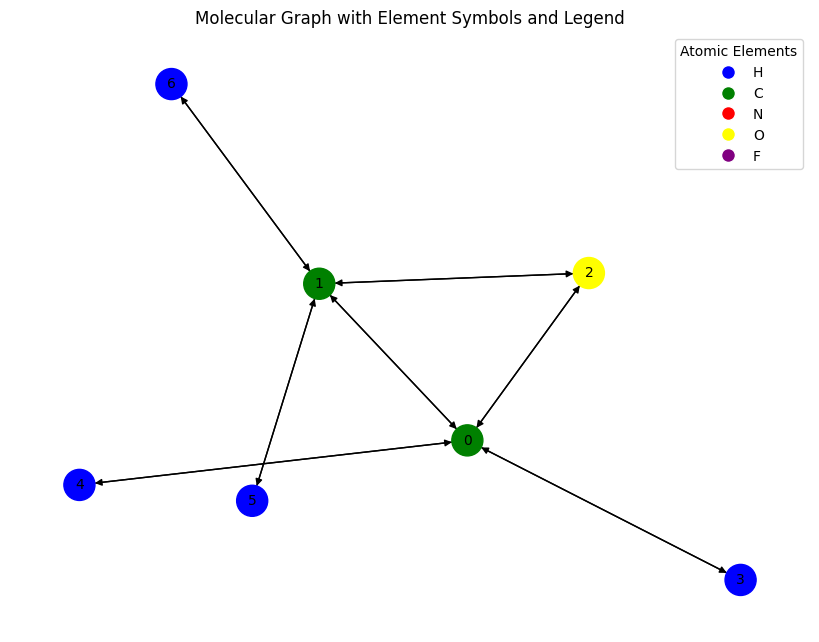

In [14]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx


# Convert PyTorch Geometric graph to NetworkX
G = to_networkx(data)

# Extract atomic numbers and corresponding elements/colors
atomic_numbers = data.x[:, 5].tolist()  # Assuming column 5 contains atomic numbers
elements = [atomic_number_to_element[int(z)] for z in atomic_numbers]
node_colors = [atomic_number_to_color[int(z)] for z in atomic_numbers]

# Create a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=atomic_number_to_element[atomic_number])
    for atomic_number, color in atomic_number_to_color.items()
]

# Node labels using element symbols
node_labels = {i: elements[i] for i in range(len(elements))}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw(
    G,
    #labels=node_labels,
    with_labels=True,
    node_color=node_colors,
    edge_color='black',
    node_size=500,
    font_size=10,
    arrows=True  # This shows direction if G is a DiGraph
)

# Add the legend
plt.legend(handles=legend_elements, loc='best', title="Atomic Elements")
plt.title("Molecular Graph with Element Symbols and Legend")
plt.show()


In [15]:
# New information can be added as

data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[7, 11], edge_index=[2, 14], edge_attr=[14, 4], y=[1, 19], pos=[7, 3], idx=[1], name='gdb_17', z=[7], new_attribute=[3])

In [16]:
data.edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 0, 2, 5, 6, 0, 1, 0, 0, 1, 1]])

In [17]:
# Remove last edge and its attr
data.edge_index = data.edge_index[:, :-1]
data.edge_attr = data.edge_attr[:-1]

In [18]:
data

Data(x=[7, 11], edge_index=[2, 13], edge_attr=[13, 4], y=[1, 19], pos=[7, 3], idx=[1], name='gdb_17', z=[7], new_attribute=[3])

In [20]:
# Convert PyTorch Geometric graph to NetworkX
Gnew = to_networkx(data)

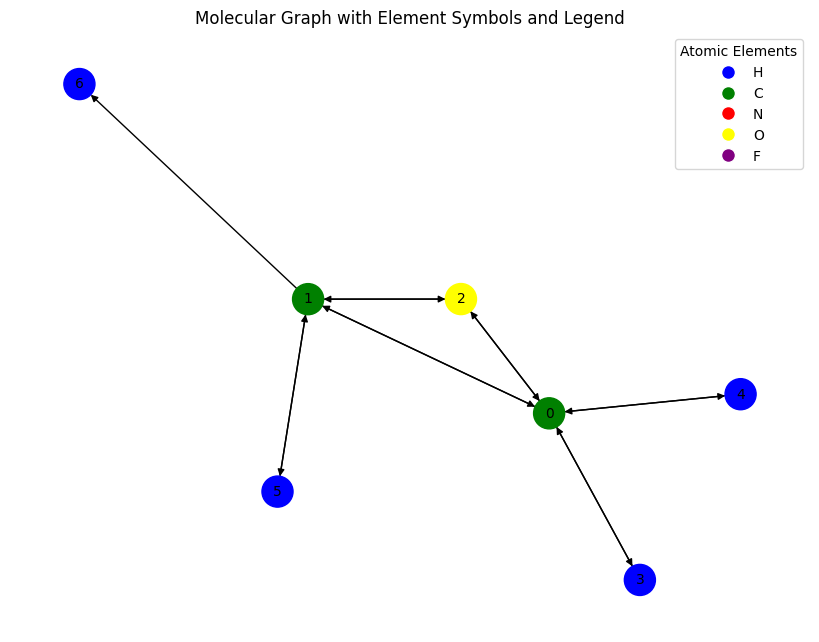

In [37]:
# Plot the new graph
plt.figure(figsize=(8, 6))
nx.draw(
    Gnew,
    #labels=node_labels,
    with_labels=True,
    node_color=node_colors,
    edge_color='black',
    node_size=500,
    font_size=10,
    arrows=True  # This shows direction if G is a DiGraph
)

# Add the legend
plt.legend(handles=legend_elements, loc='best', title="Atomic Elements")
plt.title("Molecular Graph with Element Symbols and Legend")
plt.show()

😀 notice the difference between the two graphs?

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.new_attribute.is_cuda # check if new_attribute is part of data and seen by device

True

### **NNConv: Neural Message Passing Convolution**

The `NNConv` layer in `torch_geometric.nn` implements a **continuous kernel-based convolution** operator as introduced in the [Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212) paper.

This layer is particularly designed for graph-structured data where the **edges contain important information**, such as molecular bonds or other edge features.

#### 🔍 How it works

`NNConv` generalizes the message passing framework by learning **edge-conditioned filters**:

$$
\mathbf{x}_i' = \Theta \mathbf{x}_i + \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \cdot h_{\theta}(e_{i,j})
$$

- $\mathbf{x}_i$: Feature vector of node $i$
- $\mathcal{N}(i)$: Neighborhood of node $i$
- $e_{i,j}$: Edge features between node $i$ and $j$
- $h_{\theta}$: Neural network applied to edge features to generate convolution weights; it maps edge features `[-1, num_edge_features]` to shape `[-1, in_channels * out_channels]`, e.g., defined by `torch.nn.Sequential`.
- $\Theta$: Learnable transformation for self-node feature

#### Parameters

```python
NNConv(
    in_channels,        # Input feature dimension
    out_channels,       # Output feature dimension
    nn,                 # A neural network mapping edge features to weight matrices
    aggr='add',         # Aggregation method: 'add', 'mean', or 'max'
    root_weight=True,   # Whether to add a root transformation (Θ)
    bias=True           # Include bias term
)


### **Edge-Conditioned Learning with NNConv**

This notebook demonstrates a **graph neural network (GNN)** model using **edge-conditioned convolutions**. It's particularly useful for tasks like molecular property prediction, where both **node features** (e.g., atom types) and **edge features** (e.g., bond types, bond lengths) carry important information.

---

#### 🤔 What is NNConv? Is it a GCN?

- **GCN** (Kipf & Welling) uses **fixed weights shared across all edges** — it doesn't use edge features.
- **NNConv** is a **generalization of GCN**, where each edge can have its own learnable weight matrix. These are computed dynamically from edge features via a neural network.
- This makes NNConv a **message-passing GNN layer** — still a type of graph convolution, but **edge-aware** and more expressive.

---

#### Tensor Shapes

| Symbol           | Meaning                                |
|------------------|----------------------------------------|
| `N`              | Number of nodes                        |
| `E`              | Number of edges                        |
| `F_in`           | Input features per node                |
| `F_edge`         | Input features per edge                |
| `B`              | Batch size (number of graphs)          |

---

#### Model Architecture

This GNN does the following:

1. **Inputs**: Node features and edge features.
2. **GNN Layers**: Two `NNConv` layers with neural networks to learn edge-conditioned weights.
3. **Graph Pooling**: Use `global_add_pool` to aggregate node features into a single graph-level representation.
4. **Output**: A **scalar per graph**, useful for regression tasks like predicting molecular energy.

---

#### Why Edge-Conditioned?

Edge-conditioned learning allows **message transformations** to depend on edge-specific properties — such as bond types or lengths in a molecule. This results in **more expressive models** compared to traditional GCNs that ignore edge attributes.


In [55]:
#############################################################################################################
# Below an example of how to build a message passing network using PyTorch Geometric using the NNConv layer #
#############################################################################################################



class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()

        # Remember:
        # x: Node features — shape [N, F_in]
        # edge_index: Graph connectivity — shape [2, E]
        # edge_attr: Edge features — shape [E, F_edge]

        # The following are edge-aware layers
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),    # [E, F_edge] → [E, 32]
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32)) # [E, 32] → [E, F_in*32] --- So each edge generates a [F_in × 32] transformation matrix
                                  # N.b.: you don’t want an activation at the end: adding ReLU would restrict the weight matrix to non-negative values, which limits expressivity
        # Output shape before reshaping: [E, F_in * 32]
        # Reshaped by NNConv internally to: [E, F_in, 32]

        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),     # [E, F_edge] → [E, 32]
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))                # [E, 32] → [E, 32 * 16]
        # Output shape before reshaping: [E, 32 * 16]
        # Reshaped by NNConv internally to: [E, 32, 16]

        # Can you extend to a "3rd layer"?

        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        # Input:
        #   x: [N, F_in]
        #   edge_attr: [E, F_edge]
        # Output:
        #   x: [N, 32]

        # Takes x from conv1
        self.conv2 = NNConv(32, 16, conv2_net)
        # Input:
        #   x: [N, 32]
        #   edge_attr: [E, F_edge]
        # Output:
        #   x: [N, 16]

        # N.B.: The more layers you stack, the further information can flow in the graph...
        # After 1 GNN layer (e.g., conv1), each node’s features are updated using its immediate neighbors' features.
        # After 2 layers, each node has aggregated information from its neighbors and their neighbors (2-hop neighborhood)...

        ############################ Can you extend to a "3rd layer"? ###############################

        self.fc_1 = nn.Linear(16, 32)

        self.out = nn.Linear(32, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr

        # batch = data.batch               # Shape: [N], maps each node to a graph in batch
        # x = data.x                       # Shape: [N, F_in]
        # edge_index = data.edge_index     # Shape: [2, E]
        # edge_attr = data.edge_attr       # Shape: [E, F_edge]


        # edge_weight_matrices = conv1_net(edge_attr) # [E, F_edge] -> [E, F_in * 32] reshaped [E, F_in, 32]
        # For each edge e, this gives a unique weight matrix W_e of shape [F_in, 32].
        #
        #   What does NNconv do?
        #   0. Compute the weights = conv1_net(edge_attr)  # shape: [E, F_in * 32]
        #   1. Fetch the feature vector x_j of the source node j: shape [F_in]
        #   2. Multiply it by the edge-specific matrix W_e: W_e @ x_j  →  [F_in, 32] @ [F_in] = shape [32]
        #   3. Aggregate messages at each target node i: x_i_new = sum_{j in N(i)} W_ij @ x_j = shape [32]
        #   Do this for all aggregated output: shape [N, 32]


        x = F.relu(self.conv1(x, edge_index, edge_attr))
        # input
        #   x : [N, F_in]
        #   edge_attr: [E, F_edge]
        # Output: [N, 32]

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        #   x : [N, 32]
        #   edge_attr: [E, F_edge]
        # Output: [N, 16]


        x = global_add_pool(x,batch)
        # Input:
        #   x: [N, 16]
        #   batch: [N]  → tells which of B graphs each node belongs to
        # Output: [B, 16]

        x = F.relu(self.fc_1(x)) # [B, 16] → [B, 32]
        output = self.out(x)     # [B, 32] → [B, 1]

        return output

In [56]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [57]:
qm9_node_feats, qm9_edge_feats = 11, 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
target_idx = 1 # index position of the polarizability label

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [59]:
epochs = 10

train_loss_list = []
valid_loss_list = []


for total_epochs in range(epochs):

    train_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1)) #[num_graphs] -> [num_graphs,1]
        loss.backward()
        train_loss += loss.item()
        total_graphs += batch.num_graphs  #internally defined in torch_geometric.data.Batch
        optimizer.step()

    train_avg_loss = train_loss / total_graphs

    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs

    val_avg_loss = val_loss / total_graphs


    print(f"Epochs: {total_epochs} | training avg. loss: {train_avg_loss:.3f} | validation avg. loss: {val_avg_loss:.3f}")
    train_loss_list.append(train_avg_loss)
    valid_loss_list.append(val_avg_loss)

Epochs: 0 | training avg. loss: 0.421 | validation avg. loss: 0.367
Epochs: 1 | training avg. loss: 0.141 | validation avg. loss: 0.082
Epochs: 2 | training avg. loss: 0.101 | validation avg. loss: 0.071
Epochs: 3 | training avg. loss: 0.088 | validation avg. loss: 0.076
Epochs: 4 | training avg. loss: 0.086 | validation avg. loss: 0.075
Epochs: 5 | training avg. loss: 0.082 | validation avg. loss: 0.069
Epochs: 6 | training avg. loss: 0.081 | validation avg. loss: 0.081
Epochs: 7 | training avg. loss: 0.079 | validation avg. loss: 0.056
Epochs: 8 | training avg. loss: 0.076 | validation avg. loss: 0.064
Epochs: 9 | training avg. loss: 0.075 | validation avg. loss: 0.061


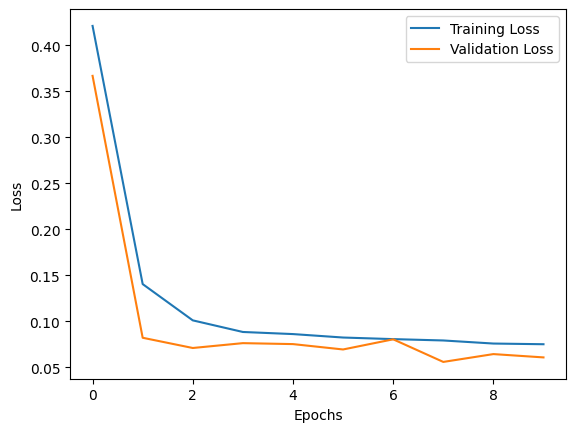

In [60]:
plt.plot(train_loss_list, label='Training Loss')
plt.plot(valid_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
net.eval() # model in evaluation mode; Disables things like Dropout and BatchNorm updates; does not disable gradient tracking
predictions = []
real = []

for batch in testloader:

    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

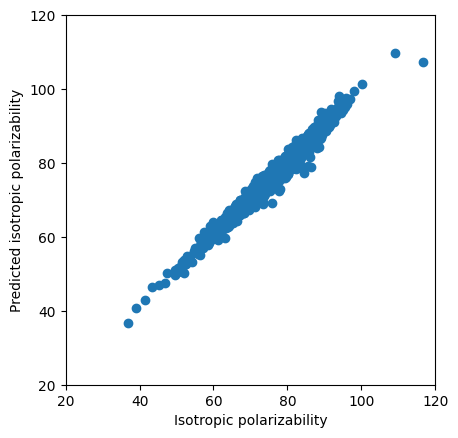

In [68]:
import matplotlib.pyplot as plt


plt.scatter(real[:2000],predictions[:2000])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
plt.xlim(20,120)
plt.ylim(20,120)
# display as square
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [67]:
from sklearn.metrics import r2_score

r2 = r2_score(real[:2000], predictions[:2000])
print(f"R² Score: {r2:.4f}")

R² Score: 0.9741


### **Extension to Multiple Layers**

**Exercise**: Let's extend the previous problem to three layers.



---



### **The Non Edge-Aware Case**

In [69]:
######################################################################################
# Below an example of how to build a message passing network which is not edge-aware #
######################################################################################


In [91]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool

class ExampleGCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super().__init__()

        # No edge_attr needed!
        # https://pytorch-geometric.readthedocs.io/en/2.5.2/generated/torch_geometric.nn.conv.GCNConv.html
        self.conv1 = GCNConv(num_node_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, 8)

        self.fc_1 = torch.nn.Linear(8, 32)
        self.out = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))   # [N, F_in] → [N, 32]
        x = F.relu(self.conv2(x, edge_index))   # [N, 32] → [N, 16]
        x = F.relu(self.conv3(x, edge_index))   # [N, 16] → [N, 8]

        x = global_add_pool(x, batch)           # [N, 8] → [B, 8]
        x = F.relu(self.fc_1(x))                # [B, 8] → [B, 32]
        output = self.out(x)                    # [B, 32] → [B, 1]

        return output


In [92]:
qm9_node_feats = 11

net_gcn = ExampleGCN(qm9_node_feats)

optimizer = torch.optim.Adam(net_gcn.parameters(), lr=0.01)
target_idx = 1 # index position of the polarizability label

In [93]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_gcn.to(device)

ExampleGCN(
  (conv1): GCNConv(11, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 8)
  (fc_1): Linear(in_features=8, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [94]:
train_loss_list = []
valid_loss_list = []

for total_epochs in range(epochs):

    train_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net_gcn(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        train_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()

    train_avg_loss = train_loss / total_graphs

    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net_gcn(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs


    print(f"Epochs: {total_epochs} | train avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")
    train_loss_list.append(train_avg_loss)
    valid_loss_list.append(val_avg_loss)

Epochs: 0 | train avg. loss: 1.06 | validation avg. loss: 0.24
Epochs: 1 | train avg. loss: 0.20 | validation avg. loss: 0.28
Epochs: 2 | train avg. loss: 0.18 | validation avg. loss: 0.14
Epochs: 3 | train avg. loss: 0.16 | validation avg. loss: 0.13
Epochs: 4 | train avg. loss: 0.15 | validation avg. loss: 0.14
Epochs: 5 | train avg. loss: 0.15 | validation avg. loss: 0.18
Epochs: 6 | train avg. loss: 0.14 | validation avg. loss: 0.12
Epochs: 7 | train avg. loss: 0.14 | validation avg. loss: 0.13
Epochs: 8 | train avg. loss: 0.14 | validation avg. loss: 0.19
Epochs: 9 | train avg. loss: 0.13 | validation avg. loss: 0.15


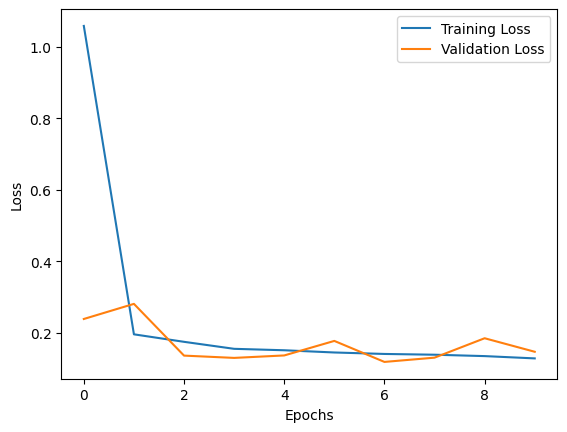

In [95]:
plt.plot(train_loss_list, label='Training Loss')
plt.plot(valid_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [96]:
net_gcn.eval() # model in evaluation mode; Disables things like Dropout and BatchNorm updates; does not disable gradient tracking
predictions = []
real = []

for batch in testloader:

    output = net_gcn(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)



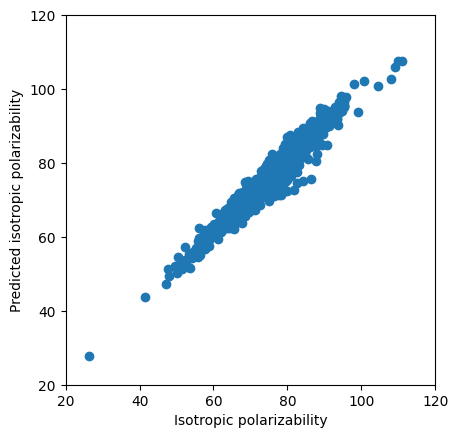

In [97]:
plt.scatter(real[:2000],predictions[:2000])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
plt.xlim(20,120)
plt.ylim(20,120)
# display as square
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [98]:
r2 = r2_score(real[:2000], predictions[:2000])
print(f"R² Score: {r2:.4f}")

R² Score: 0.9379
